In [6]:
# 导入相关库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [7]:
# 读取训练数据
data_train = pd.read_csv("D:/restaurant-revenue-prediction/train.csv.zip")

In [8]:
data_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [10]:
# 检查空值
data_train.isna().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

In [11]:
# 检查我们正在处理的所有城市和省份 
data_train.City.unique()

array(['İstanbul', 'Ankara', 'Diyarbakır', 'Tokat', 'Gaziantep',
       'Afyonkarahisar', 'Edirne', 'Kocaeli', 'Bursa', 'İzmir', 'Sakarya',
       'Elazığ', 'Kayseri', 'Eskişehir', 'Şanlıurfa', 'Samsun', 'Adana',
       'Antalya', 'Kastamonu', 'Uşak', 'Muğla', 'Kırklareli', 'Konya',
       'Karabük', 'Tekirdağ', 'Denizli', 'Balıkesir', 'Aydın', 'Amasya',
       'Kütahya', 'Bolu', 'Trabzon', 'Isparta', 'Osmaniye'], dtype=object)

In [12]:
# 数据中的省市数量
len(data_train.City.unique())

34

In [13]:
# 正在处理的城市类型
data_train['City Group'].unique()

array(['Big Cities', 'Other'], dtype=object)

Big Cities    78
Other         59
Name: City Group, dtype: int64

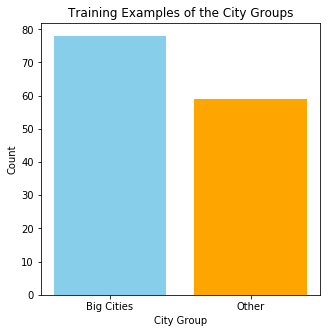

In [14]:
bigCities = len(data_train[data_train['City Group'] == "Big Cities"])
otherCount = len(data_train[data_train['City Group'] == "Other"])
dic_1 = {"Big Cities": bigCities, "Other": otherCount}

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(dic_1.keys(), 
       dic_1.values(), 
       width=0.8, 
       color=['skyblue', 'orange'])
ax.set(xlabel= "City Group", 
       ylabel='Count',
       title='Training Examples of the City Groups');
data_train['City Group'].value_counts()

In [15]:
data_train['Type'].value_counts()

FC    76
IL    60
DT     1
Name: Type, dtype: int64

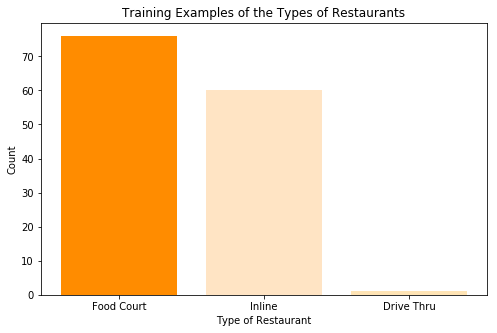

In [16]:
fc = len(data_train[data_train['Type'] == "FC"])
il = len(data_train[data_train['Type'] == "IL"])
dt = len(data_train[data_train['Type'] == "DT"])
dic_2 = {'Food Court': fc ,"Inline": il , "Drive Thru": dt}

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(dic_2.keys(), 
       dic_2.values(), 
       width=0.8, 
       color=['darkorange', 'bisque', 'moccasin'])
ax.set(xlabel='Type of Restaurant', 
       ylabel='Count',
       title='Training Examples of the Types of Restaurants');

In [17]:
data_train['Open Date'].dtype

dtype('O')

In [18]:
# 将“开业日期”列转换为日期时间数据类型
data_train['Open Date'] = pd.to_datetime(data_train['Open Date'])

In [19]:
data_train['Open Date'].dtype

dtype('<M8[ns]')

In [20]:
# 按年份按升序对值进行排序
data_train.sort_values(by=['Open Date'], inplace=True, ascending=True, ignore_index=True)

In [21]:
data_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,35,1996-05-08,Adana,Other,IL,4,5.0,4.0,3.0,1,...,2.0,4,1,3,3,3,4,3,3,3903884.0
1,122,1997-04-10,İstanbul,Big Cities,IL,12,7.5,6.0,7.5,2,...,2.5,25,15,25,6,18,3,16,6,4286645.0
2,28,1998-01-28,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,...,2.0,3,5,5,2,3,5,4,4,4705945.0
3,112,1998-03-14,İstanbul,Big Cities,IL,4,5.0,5.0,4.0,1,...,3.0,3,2,1,2,2,1,3,3,3784230.0
4,64,1998-07-13,İstanbul,Big Cities,IL,12,7.5,6.0,6.0,2,...,7.5,20,15,25,4,24,15,20,6,2551252.0


In [22]:
# 为开业日期值添加单独的列
data_train['Sale Day'] = data_train['Open Date'].dt.day
data_train['Sale Year'] = data_train['Open Date'].dt.year
data_train['Sale Month'] = data_train['Open Date'].dt.month

In [23]:
data_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P32,P33,P34,P35,P36,P37,revenue,Sale Day,Sale Year,Sale Month
0,35,1996-05-08,Adana,Other,IL,4,5.0,4.0,3.0,1,...,3,3,3,4,3,3,3903884.0,8,1996,5
1,122,1997-04-10,İstanbul,Big Cities,IL,12,7.5,6.0,7.5,2,...,25,6,18,3,16,6,4286645.0,10,1997,4
2,28,1998-01-28,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,...,5,2,3,5,4,4,4705945.0,28,1998,1
3,112,1998-03-14,İstanbul,Big Cities,IL,4,5.0,5.0,4.0,1,...,1,2,2,1,3,3,3784230.0,14,1998,3
4,64,1998-07-13,İstanbul,Big Cities,IL,12,7.5,6.0,6.0,2,...,25,4,24,15,20,6,2551252.0,13,1998,7


In [24]:
data_train['Sale Year'].value_counts()

2011    25
2012    18
2009    16
2010    15
2008    14
2013    12
2006     7
2007     7
1999     4
2005     4
1998     4
2004     3
2014     2
2000     2
2002     2
1997     1
1996     1
Name: Sale Year, dtype: int64

In [25]:
# 在列表中存储分类变量名
ctg_vars = []

for col in data_train:
    if len(data_train[col].unique()) <= 30:
        ctg_vars.append(col)

In [26]:
# 从分类变量列表中删除P变量
i = 1
for k in range(1, 43):
    for p in ctg_vars:
        if p == "P" + str(i):
            ctg_vars.remove("P" + str(i))
            i += 1

In [27]:
print(ctg_vars)

['City Group', 'Type', 'Sale Day', 'Sale Year', 'Sale Month']


In [28]:
len(ctg_vars)

5

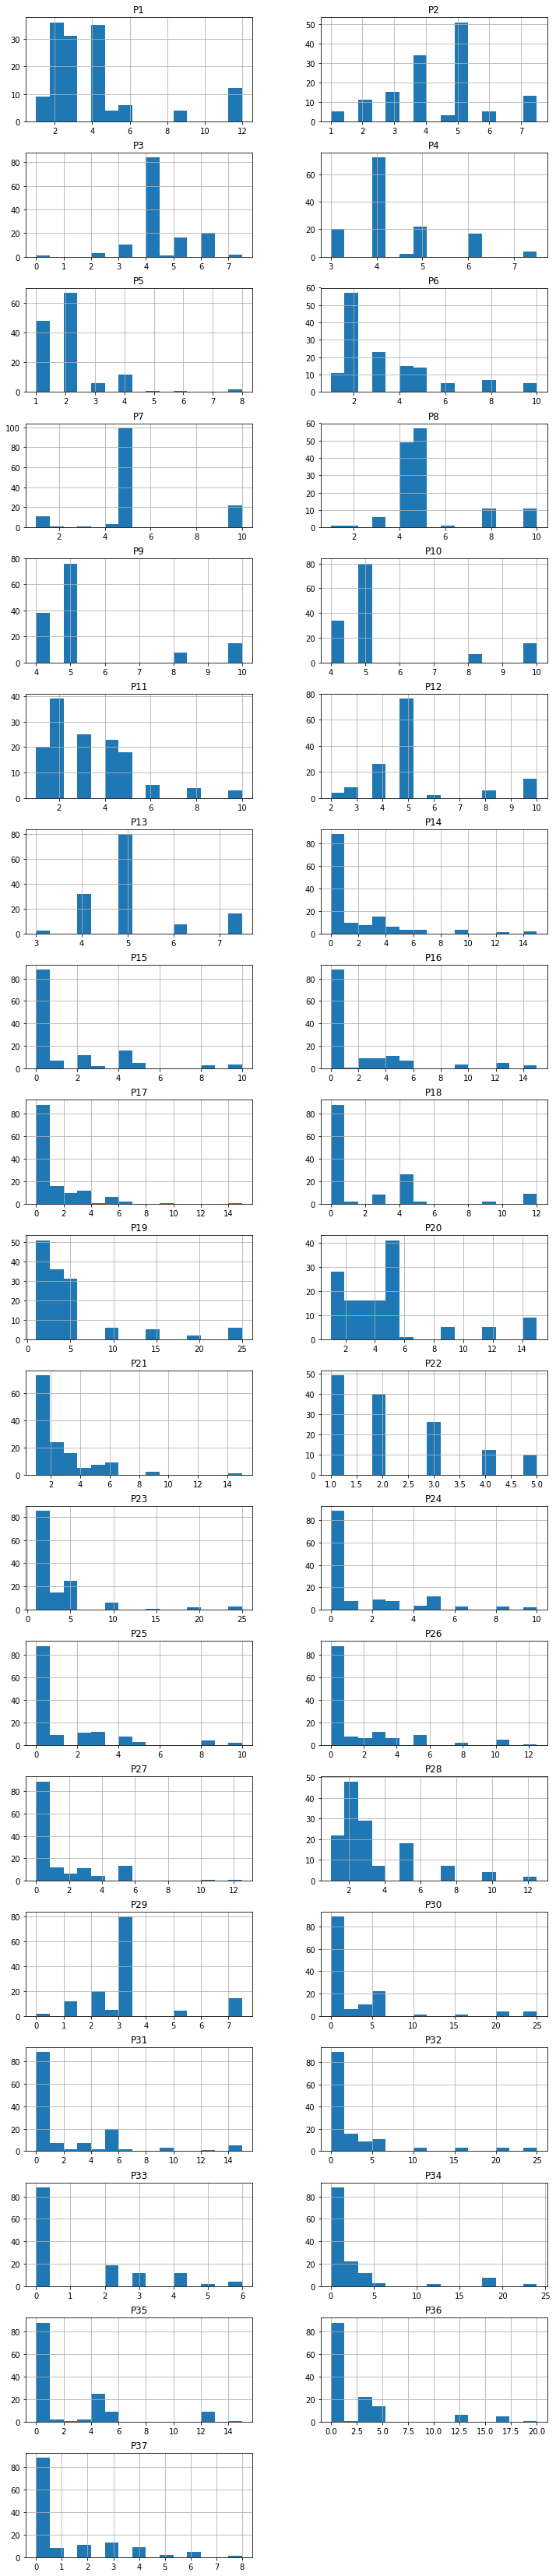

In [29]:
#绘制所有P列和收入列的直方图
hist_cols = list(data_train.columns[4:42])
data_train[hist_cols].hist(figsize= (12,60), layout=(19,2), bins=15);

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


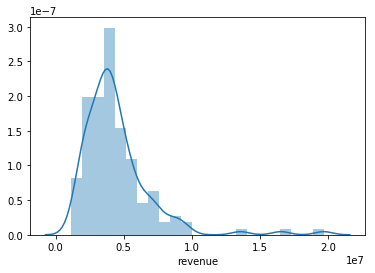

In [30]:
sns.distplot(data_train['revenue']);

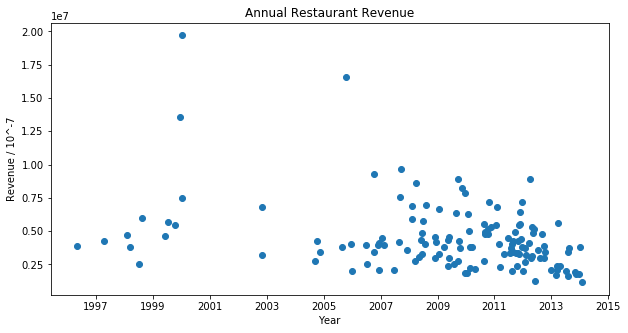

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(data_train['Open Date'], data_train['revenue'])
ax.set(ylabel="Revenue / 10^-7",
       xlabel='Year',
       title='Annual Restaurant Revenue');

Median Revenue of Big cities: 4234908.0
Median Revenue of Other cities: 3745135.0


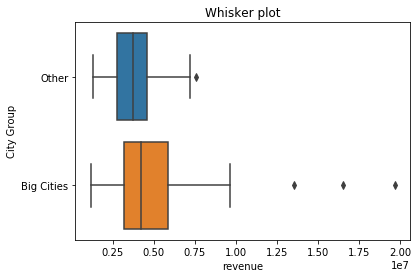

In [32]:
# 大城市和其他城市的收入中值
ax_wp_1 = sns.boxplot(x='revenue', y='City Group', data=data_train)
ax_wp_1.set(title='Whisker plot');

bc_median = data_train[data_train['City Group'] == 'Big Cities']['revenue'].median()
oc_median = data_train[data_train['City Group'] == 'Other']['revenue'].median()
print("Median Revenue of Big cities:", bc_median)
print("Median Revenue of Other cities:", oc_median)

In [33]:
data_train['revenue'].max()

19696939.0

In [34]:
# 各类餐厅的收入中位数 
rt_median = data_train.groupby('Type')['revenue'].aggregate(np.median)
print("Median Revenue of the types of restaurants per annum: \n", rt_median[1:])

Median Revenue of the types of restaurants per annum: 
 Type
FC    3873650.0
IL    4076087.0
Name: revenue, dtype: float64


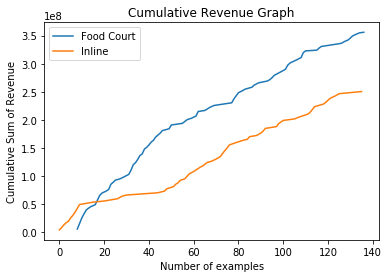

In [35]:
data_train[data_train['Type'] == 'FC']['revenue'].cumsum().plot()
data_train[data_train['Type'] == 'IL']['revenue'].cumsum().plot()
plt.ylabel('Cumulative Sum of Revenue')
plt.xlabel('Number of examples')
plt.legend(['Food Court', 'Inline'])
plt.title('Cumulative Revenue Graph');

In [36]:
# 收入最高的餐厅类型
data_train[data_train['revenue'] == data_train['revenue'].max()]['Type']

10    FC
Name: Type, dtype: object

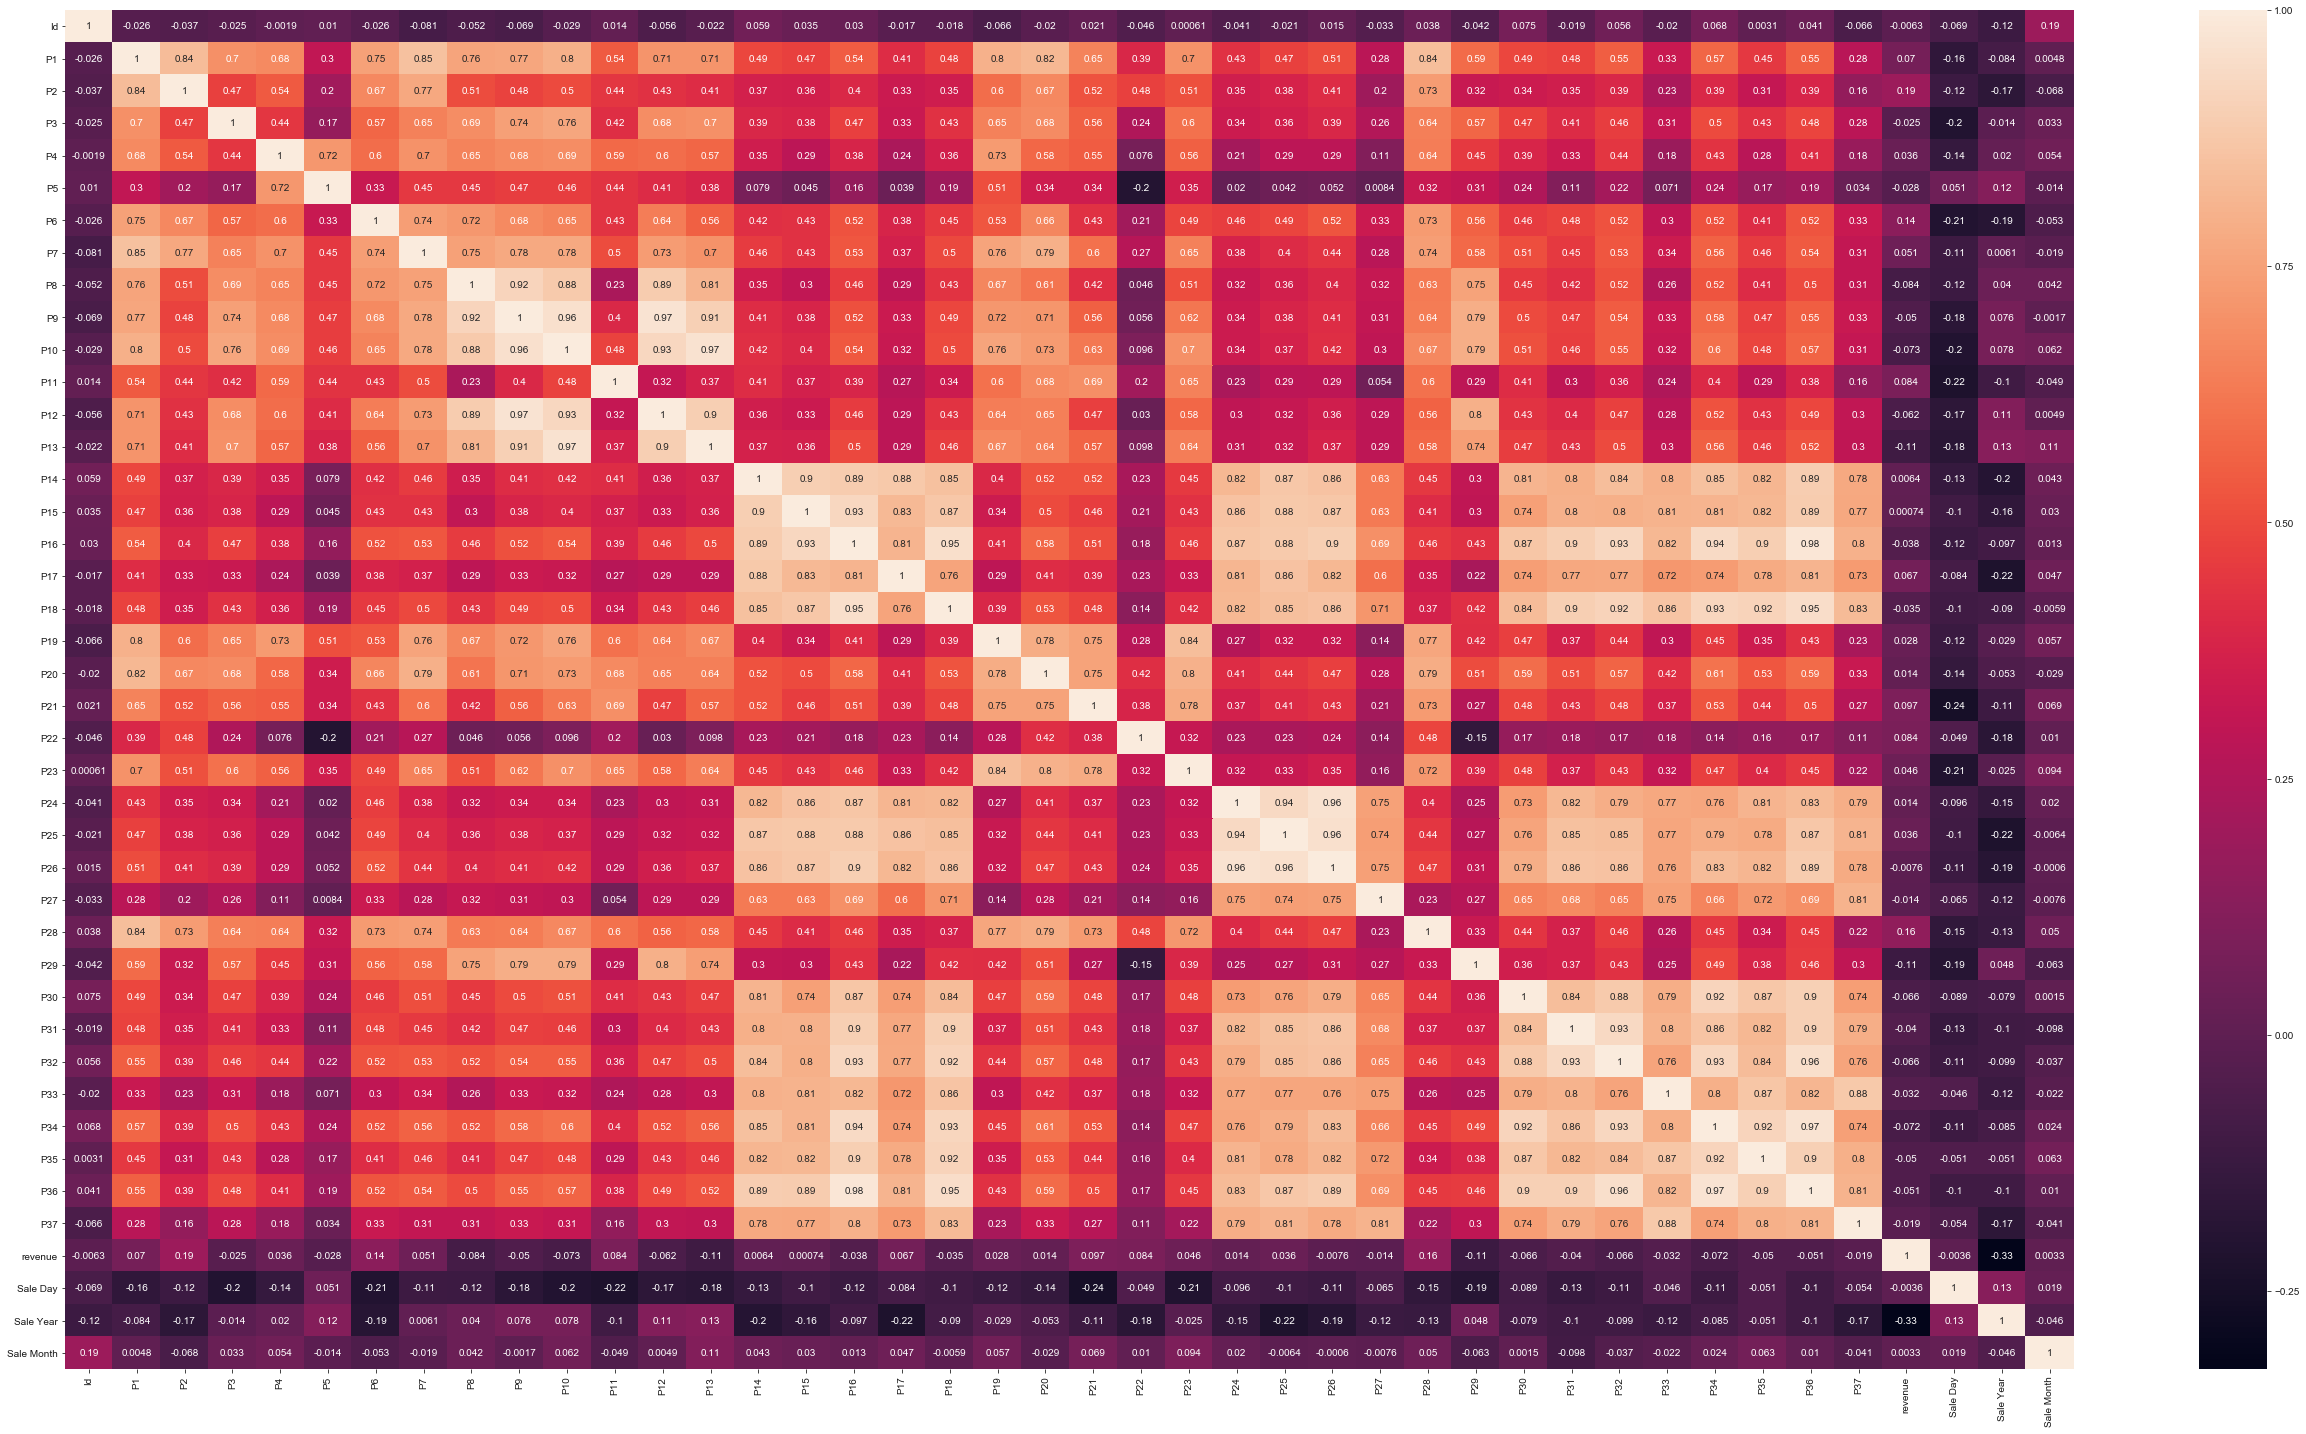

In [37]:
plt.figure(figsize=(45,25))
sns.heatmap(data_train.corr(),annot=True)
sns.set(font_scale=1.4)

In [38]:
# P变量将被视为连续变量，而不是分类变量
imp_train = IterativeImputer(max_iter=30, random_state=0, missing_values=0, sample_posterior = True, min_value=1)
p_vals = ["P" + str(i) for i in range(1, 38)]
data_train[p_vals] = np.round(imp_train.fit_transform(data_train[p_vals]))

In [39]:
data_temp = data_train.copy()

In [40]:
data_temp.drop('Open Date', axis=1, inplace=True)
data_temp.drop('City', axis=1, inplace=True)

In [41]:
data_temp['revenue'] = np.log1p(data_temp['revenue'])

In [42]:
data_temp.to_csv('train_data_modified.csv', index=False)

In [43]:
# 加载临时数据
data = pd.read_csv('train_data_modified.csv')

In [44]:
data = pd.get_dummies(data, columns=ctg_vars)

In [45]:
# 向数据集中添加新列以匹配输入功能
data['Sale Year_1995'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')
data['Sale Year_2001'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')
data['Sale Year_2003'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')
data['Sale Day_19'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')

In [46]:
X = data.drop('revenue', axis=1)
y = data['revenue']

In [47]:
# 分割数据
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [48]:
# 创建随机森林回归模型 
model = RandomForestRegressor(n_estimators=1000 ,random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [49]:

# 评价函数

def rmse(y_test, y_preds):
    return np.sqrt(mean_squared_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Validating MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSE": rmse(y_train, train_preds),
              "Validating RMSE": rmse(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Validating R^2": model.score(X_valid, y_valid)}
    return scores

In [50]:
show_scores(model)

{'Training MAE': 0.12461725351154924,
 'Validating MAE': 0.3132217181152138,
 'Training RMSE': 0.1654624075707405,
 'Validating RMSE': 0.3425361189023099,
 'Training R^2': 0.8852393462878158,
 'Validating R^2': 0.16481374935686788}

In [51]:
# 模型2 - CatBoost
from catboost import CatBoostRegressor
model_2 = CatBoostRegressor(verbose=False)
model_2.fit(X_train, y_train);

In [52]:
cat_pred = model_2.predict(X_valid)

In [53]:
show_scores(model_2)

{'Training MAE': 0.010882872813613987,
 'Validating MAE': 0.3107052935210691,
 'Training RMSE': 0.013000659336630561,
 'Validating RMSE': 0.35517226009634406,
 'Training R^2': 0.9992915240834971,
 'Validating R^2': 0.10205720819413622}

In [54]:

# Number of trees
trees = np.arange(100, 1000, 100)

for i in trees:
    print("Number of Trees: {}".format(i))
    rf_test_model = RandomForestRegressor(n_estimators=i, random_state=0, criterion='mae')
    rf_test_model.fit(X_train, y_train)
    train_preds = rf_test_model.predict(X_train)
    val_preds = rf_test_model.predict(X_valid)
    print('RMSE for training set: {}'.format(rmse(y_train, train_preds)))
    print('RMSE for validation set: {} \n'.format(rmse(y_valid, val_preds)))

Number of Trees: 100


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.1745554939608672
RMSE for validation set: 0.40437947257900964 

Number of Trees: 200


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.16780572102270722
RMSE for validation set: 0.3804870627248734 

Number of Trees: 300


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.1691076439192461
RMSE for validation set: 0.37003049142514205 

Number of Trees: 400


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.16914546391729662
RMSE for validation set: 0.36823729509854 

Number of Trees: 500


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.17019256884696918
RMSE for validation set: 0.3648544303761767 

Number of Trees: 600


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.17046282548569155
RMSE for validation set: 0.3665803631480881 

Number of Trees: 700


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.17113701833427963
RMSE for validation set: 0.36819284659179496 

Number of Trees: 800


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.17148621991352647
RMSE for validation set: 0.36873185386697316 

Number of Trees: 900


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.17142372126429894
RMSE for validation set: 0.3697301762545562 



In [55]:
# Parameter dictionary for GridSearch
rf_grid = {'n_estimators': [200, 600, 800],
           'criterion': ['mse', 'mae'],
           'max_features': [0.33, 0.5, 'auto', 'sqrt'],       
           }

In [56]:


rf_gs = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid = rf_grid,
                     cv = 5,
                     verbose = True)

rf_gs.fit(X_train, y_train)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensem

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensem

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\e

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:399: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\e

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': [0.33, 0.5, 'auto', 'sqrt'],
                         'n_estimators': [200, 600, 800]},
             verbose=True)

In [58]:
rf_gs.score(X_valid, y_valid)

0.19613243555662718

In [59]:
rf_gs.score(X_train, y_train)

0.8854009550406302

In [60]:
rf_gs.best_params_

{'criterion': 'mse', 'max_features': 0.5, 'n_estimators': 600}

In [62]:
rf_gs.best_params_['n_estimators']

600

In [63]:
rf_test_model = RandomForestRegressor(n_estimators=rf_gs.best_params_['n_estimators'], random_state=0, 
                                      criterion=rf_gs.best_params_['criterion'], max_features = rf_gs.best_params_['max_features'])
rf_test_model.fit(X_train, y_train)
train_preds = rf_test_model.predict(X_train)
val_preds = rf_test_model.predict(X_valid)
print('RMSE for training set: {}'.format(rmse(y_train, train_preds)))
print('RMSE for validation set: {}'.format(rmse(y_valid, val_preds)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RMSE for training set: 0.16486895227284903
RMSE for validation set: 0.33808214303763656


In [64]:
data_test = pd.read_csv("D:/restaurant-revenue-prediction/test.csv.zip")

In [65]:
data_test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


In [66]:
data_test.isna().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
dtype: int64

In [67]:
len(data_test.City.unique())

57

In [68]:
data_test['Type'].unique()

array(['FC', 'IL', 'DT', 'MB'], dtype=object)

In [69]:
data_test['Open Date'] = pd.to_datetime(data_test['Open Date'])
data_test.sort_values(by=['Open Date'], inplace=True, ascending=True, ignore_index=True)

In [70]:
data_test['Open Date'].dtype

dtype('<M8[ns]')

In [71]:
data_test['Sale Day'] = data_test['Open Date'].dt.day
data_test['Sale Year'] = data_test['Open Date'].dt.year
data_test['Sale Month'] = data_test['Open Date'].dt.month

In [72]:
ctg_vars_test = []

for col in data_test:
    if len(data_test[col].unique()) <= 31:
        ctg_vars_test.append(col)

In [73]:
# Remove the P variables
i = 1
for k in range(1, 43):
    for p in ctg_vars_test:
        if p == "P" + str(i):
            ctg_vars_test.remove("P" + str(i))
            i += 1

In [74]:
print(ctg_vars_test)

['City Group', 'Type', 'Sale Day', 'Sale Year', 'Sale Month']


In [75]:
data_temp_test = data_test.copy()

In [76]:
data_temp_test.loc[data_temp_test['Type'] == 'MB', 'Type'] = 'DT'

In [77]:
imp_test = IterativeImputer(max_iter=30, random_state=0, missing_values=0, sample_posterior = True, min_value=1)
p_vals_test = ["P" + str(i) for i in range(1, 38)]
data_temp_test[p_vals_test] = np.round(imp_test.fit_transform(data_temp_test[p_vals_test]))

In [78]:
data_temp_test = pd.get_dummies(data_temp_test, columns=ctg_vars_test)

In [79]:
data_temp_test.to_csv('test_data_modified.csv', index=False)

In [80]:
test_data = pd.read_csv('test_data_modified.csv')

In [84]:
submission = pd.DataFrame(columns=["Id", "Prediction"])
submission["Id"] = test_data['Id']

# 随机森林模型预测
rf_pred_sub = rf_test_model.predict(test_data.drop('Id', axis=1))
submission['Prediction'] = np.expm1(rf_pred_sub)
submission.to_csv('submission_random_forest.csv', index=False)

# CatBoost模型预测
cb_pred_sub = model_2.predict(test_data.drop('Id', axis=1))
submission['Prediction'] = np.expm1(cb_pred_sub)
submission.to_csv('submission_cat_boost.csv', index=False)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="1995-05-08": Cannot convert 'b'1995-05-08'' to float